# Author Attribution Using Stylometry

## Setup
Install the necessary packages, import the required libraries, and download the NLTK datasets to ensure proper execution of the notebook. Additionally, optional code blocks are provided for enabling GPU support when running on Google Colab.

In [ ]:
%pip install 'accelerate>=0.26.0'
%pip install huggingface_hub[hf_xet]
%pip install matplotlib
%pip install nltk
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install torch
%pip install transformers[torch]

In [ ]:
from collections import Counter
from nltk import pos_tag
from nltk.corpus import gutenberg
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
import torch

In [ ]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

#### Enabling GPU for Google Colab

In [ ]:
!apt install -y libcudnn8

##### Test if GPU is Connected

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Data Loader
This section is responsible for preparing text data from the Gutenberg corpus for analysis. Functions include:

- `get_gutenberg_fileids()`: retrieves file IDs 
- `get_samples()`: extracts text samples

### Get File IDs
The `get_gutenberg_fileids()` function generates a list of file IDs, which were manually divided into smaller subsets to ensure efficient execution of embedding and training processes.

In [ ]:
def get_gutenberg_fileids():
    """
    Get the list of file IDs from the Gutenberg corpus.

    Args:
        None

    Returns:
        list: A list of file IDs available in the Gutenberg corpus.
    """
    file_ids = gutenberg.fileids()

    return file_ids

In [ ]:
get_gutenberg_fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

### Dividing the Dataset

To manage the size of the Gutenberg corpus and avoid exceeding runtime limits, the dataset was divided into smaller subsets. Each subset contains texts from three distinct authors and is designed to be processed within 45 minutes or less on a GPU. For testing purposes, the following file IDs are recommended as they represent shorter texts in the corpus:

```python
file_ids = [['blake-poems.txt', 'shakespeare-macbeth.txt']]
```

In [ ]:
file_ids1 = ['austen-emma.txt', 'chesterton-brown.txt', 'shakespeare-hamlet.txt']
file_ids2 = ['bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt']
file_ids3 = ['burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt']
file_ids4 = ['austen-persuasion.txt', 'chesterton-thursday.txt', 'shakespeare-macbeth.txt']
file_ids5 = ['melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt']
file_ids6 = ['austen-sense.txt', 'edgeworth-parents.txt', 'whitman-leaves.txt']

### Get Text Samples
The `get_samples()` function splits the corpus into manageable chunks, removes metadata (headers and footers), tokenizes the text, and creates overlapping word chunks, associating each chunk with its corresponding author/file ID. This prepares the data for feature extraction and model training.

In [9]:
def get_samples(file_ids, chunk_size=2000, overlap=0):
    """
    Extract text samples from the corpus.

    Args:
        chunk_size: Size of each text sample in words
        overlap: Number of words to overlap between consecutive chunks

    Returns:
        List of (text, author) tuples
    """
    samples = []

    for file_id in file_ids:
        text = gutenberg.raw(file_id)

        # Clean text by removing metadata (usually at the beginning and end)
        # This is a simple approach - might need refinement for specific corpora
        lines = text.split('\n')
        start_idx = 0
        end_idx = len(lines)

        # Find start of main text (skip headers)
        for i, line in enumerate(lines):
            if "*** START OF" in line:
                start_idx = i + 1
                break

        # Find end of main text (skip footers)
        for i, line in enumerate(lines[::-1]):
            if "*** END OF" in line:
                end_idx = len(lines) - i - 1
                break

        clean_text = ' '.join(lines[start_idx:end_idx])

        # Split into chunks
        words = word_tokenize(clean_text)
        step = chunk_size - overlap

        for i in range(0, len(words) - chunk_size + 1, step):
            chunk = ' '.join(words[i:i+chunk_size])
            samples.append((chunk, file_id))

    return samples

## Style Feature Extractor
This section focuses on extracting stylometric features from text at three levels: 
- character
- word
- syntax

It includes functions for computing individual features and a unified function to aggregate all feature types.

### Character Features
Computes the following features for a given text sample:
- average word length
- punctuation frequency
- uppercase frequency
- digit frequency
- n-grams
- top 5 bigrams and trigrams

In [ ]:
def extract_character_features(text):
    """
    Extract character-level features.

    Args:
        text (str): The input text for feature extraction.

    Returns:
        dict: A dictionary containing character-level features such as average word length,
              punctuation frequency, uppercase frequency, digit frequency, and top character n-grams.
    """
    features = {}

    # Average word length
    words = word_tokenize(text.lower())
    if words:
        features['avg_word_length'] = sum(len(word) for word in words) / len(words)
    else:
        features['avg_word_length'] = 0

    # Punctuation frequency
    punct_count = sum(1 for char in text if char in ".,;:!?-\"'()[]{}")
    features['punct_freq'] = punct_count / len(text) if len(text) > 0 else 0

    # Uppercase frequency
    uppercase_count = sum(1 for char in text if char.isupper())
    features['uppercase_freq'] = uppercase_count / len(text) if len(text) > 0 else 0

    # Digit frequency
    digit_count = sum(1 for char in text if char.isdigit())
    features['digit_freq'] = digit_count / len(text) if len(text) > 0 else 0

    # Character n-grams (bigrams and trigrams)
    char_bigrams = [text[i:i+2] for i in range(len(text)-1)]
    char_trigrams = [text[i:i+3] for i in range(len(text)-2)]

    # Top 5 character bigrams and trigrams
    if char_bigrams:
        bigram_counts = Counter(char_bigrams)
        for i, (bigram, _) in enumerate(bigram_counts.most_common(5)):
            features[f'top_char_bigram_{i+1}'] = bigram

    if char_trigrams:
        trigram_counts = Counter(char_trigrams)
        for i, (trigram, _) in enumerate(trigram_counts.most_common(5)):
            features[f'top_char_trigram_{i+1}'] = trigram

    return features

### Word Features
Computes the following features for a given text sample:
- vocab richness
- average sentence length
- function work usage

In [ ]:
def extract_word_features(text):
    """
    Extract word-level features.

    Args:
        text (str): The input text for feature extraction.

    Returns:
        dict: A dictionary containing word-level features such as vocabulary richness,
              average sentence length, and function word frequencies.
    """
    features = {}
    words = word_tokenize(text.lower())

    if not words:
        return {'vocab_richness': 0, 'avg_sentence_length': 0}

    # Vocab richness (type-token ratio)
    features['vocab_richness'] = len(set(words)) / len(words)

    # Average sentence length
    sentences = sent_tokenize(text)
    if sentences:
        words_per_sentence = [len(word_tokenize(s)) for s in sentences]
        features['avg_sentence_length'] = sum(words_per_sentence) / len(sentences)
    else:
        features['avg_sentence_length'] = 0

    # Function word usage (common words like 'the', 'and', 'of', etc.)
    function_words = ['the', 'and', 'of', 'to', 'a', 'in', 'that', 'is', 'was', 'for']
    for word in function_words:
        features[f'freq_{word}'] = words.count(word) / len(words)

    return features

### Syntax Features
Computes the following features for a given text sample:
- POS tag frequencies
- count of main POS categories (nouns, verbs, adjectives, and adverbs)

In [ ]:
def extract_syntax_features(text):
    """
    Extract syntax-level features.

    Args:
        text (str): The input text for feature extraction.

    Returns:
        dict: A dictionary containing frequencies of main POS categories (nouns, verbs, adjectives, adverbs).
    """
    features = {}

    # POS tag frequencies
    words = word_tokenize(text)
    if not words:
        return {'noun_freq': 0, 'verb_freq': 0, 'adj_freq': 0, 'adv_freq': 0}

    pos_tags = pos_tag(words)
    pos_counts = Counter(tag for _, tag in pos_tags)

    # Calculate frequencies of main POS categories
    total_tags = len(pos_tags)
    features['noun_freq'] = sum(pos_counts[tag] for tag in pos_counts if tag.startswith('NN')) / total_tags
    features['verb_freq'] = sum(pos_counts[tag] for tag in pos_counts if tag.startswith('VB')) / total_tags
    features['adj_freq'] = sum(pos_counts[tag] for tag in pos_counts if tag.startswith('JJ')) / total_tags
    features['adv_freq'] = sum(pos_counts[tag] for tag in pos_counts if tag.startswith('RB')) / total_tags

    return features

### All Features
An aggregation function to combine all features into a unified representation to enable detailed analysis of writing style.


In [ ]:
def extract_all_features(text):
    """
    Extract all stylometric features from text.

    Args:
        text (str): The input text for feature extraction.

    Returns:
        dict: A dictionary containing combined character, word, and syntax features.
    """
    character_features = extract_character_features(text)
    word_features = extract_word_features(text)
    syntax_features = extract_syntax_features(text)

    # Combine all features
    all_features = {**character_features, **word_features, **syntax_features}

    return all_features

## Transformer Feature Extractor
This section uses the pre-trained transformer model  BERT to generate embeddings for text samples. The `extract_embeddings()` function tokenizes text, processes it through the transformer model, and extracts embeddings from the model's output..


In [ ]:
def extract_embeddings(samples, max_length=512):
    """
    Extract embeddings from transformer model.

    Args:
        samples: List of text samples
        max_length: Maximum token length for the model

    Returns:
        Numpy array of embeddings
    """
    model_name='bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []

    for sample in samples:
        # Tokenize and prepare input
        inputs = tokenizer(sample, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)

        # Get model outputs
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the first token as the text representation
        # Shape: [batch_size, hidden_size]
        embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(embedding.flatten())

    return np.array(embeddings)

## Author Attributor
This section implements pipelines for author attribution using two approaches: 
- feature-based stylometry
- transformer-based embeddings

It encompasses data preparation, model training, prediction, and evaluation, providing a comparative analysis of their performance, accuracy, and agreement.

### Feature Based Stylometry
Author attribution pipeline using handcrafted stylometric features. Functions include: 
- `prepare_data()`: data preparation, feature extraction (character, word, and syntax levels)
- `train()`: model training using  SVM and Random Forest classifiers
- `predict()`: predicts the author of a given text sample

The runs for each subset of data are processed and analyzed in dedicated subsections for clarity.

#### Data Prep
Prepares data for model training by generating labels, extracting features, and mapping authors to indices.

In [ ]:
def prepare_data(samples):
    """
    Prepare data for training.

    Args:
        samples: List of (text, author) tuples

    Returns:
        feature_matrix: Feature matrix
        labels: Target labels
        feature_names: List of feature names
        author_to_idx: Mapping from author names to indices
    """
    texts, authors = zip(*samples)

    # Create label mapping
    unique_authors = sorted(set(authors))
    author_to_idx = {author: i for i, author in enumerate(unique_authors)}
    labels = np.array([author_to_idx[author] for author in authors])

    # Extract features
    features = [extract_all_features(text) for text in texts]
    feature_names = list(features[0].keys())
    feature_matrix = np.array([[float(feat.get(name, 0)) if str(feat.get(name, 0)).replace('.', '', 1).isdigit() else 0 for name in feature_names] for feat in features])

    # return feature_matrix, labels, author_to_idx
    return feature_matrix, labels, feature_names, author_to_idx

#### Train
Trains an author attribution model using stylometric features. It evaluates both SVM and Random Forest classifiers, selects the best-performing model, and provides validation metrics including accuracy, precision, recall, and confusion matrix.

In [ ]:
def train(feature_matrix, labels):
    """
    Train the author attribution model.

    Args:
        feature_matrix: Feature matrix
        labels: Target labels

    Returns:
        model: The trained model with the best performance on the validation set.
    """
    X_train, X_val, y_train, y_val = train_test_split(feature_matrix, labels, test_size=0.2, random_state=42)

    # Try both SVM and Random Forest
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', probability=True))
    ])

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Find best hyperparameters for SVM
    svm_param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.1, 0.01]
    }
    svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='f1_macro')
    svm_grid.fit(X_train, y_train)

    # Find best hyperparameters for Random Forest
    rf_param_grid = {
        'rf__n_estimators': [50, 100],
        'rf__max_depth': [None, 10, 20]
    }
    rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='f1_macro')
    rf_grid.fit(X_train, y_train)

    # Compare both models
    print(f"SVM best score: {svm_grid.best_score_}")
    print(f"Random Forest best score: {rf_grid.best_score_}")

    # Select the better model
    if svm_grid.best_score_ >= rf_grid.best_score_:
        model = svm_grid.best_estimator_
        print(f"Selected SVM with params: {svm_grid.best_params_}")
    else:
        model = rf_grid.best_estimator_
        print(f"Selected Random Forest with params: {rf_grid.best_params_}")

    # Evaluate on validation set
    y_pred = model.predict(X_val)
    print("\nValidation Set Performance:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

    return model

#### Predict
Predicts the authors of text samples using a trained feature-based model. Outputs the predicted author indices for the given feature matrix.

In [ ]:
def predict(model, feature_matrix):
    """
    Predict authors for texts.

    Args:
        feature_matrix: Feature matrix for texts

    Returns:
        Predicted author indices
    """

    return model.predict(feature_matrix)

#### Subset Runs

##### Set 1
- austen-emma.txt
- chesterton-brown.txt
- shakespeare-hamlet.txt

In [ ]:
samples1 = get_samples(file_ids1, chunk_size=50, overlap=10)
print(f"Samples: {samples1[:2]}")

feature_matrix1, labels1, feature_names1, author_to_idx1 = prepare_data(samples1)
print(f"Feature matrix shape: {feature_matrix1.shape}")
print(f"Labels shape: {labels1.shape}")
print(f"Feature names: {feature_names1[:5]}")
print(f"Author to index mapping: {author_to_idx1}")

Samples: [('[ Emma by Jane Austen 1816 ] VOLUME I CHAPTER I Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty-one years in the world with', 'austen-emma.txt'), ("and had lived nearly twenty-one years in the world with very little to distress or vex her . She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister 's marriage , been mistress of his house", 'austen-emma.txt')]
Feature matrix shape: (7842, 30)
Labels shape: (7842,)
Feature names: ['avg_word_length', 'punct_freq', 'uppercase_freq', 'digit_freq', 'top_char_bigram_1']
Author to index mapping: {'austen-emma.txt': 0, 'chesterton-brown.txt': 1, 'shakespeare-hamlet.txt': 2}


In [ ]:
model1 = train(feature_matrix1, labels1)

SVM best score: 0.7690068541341261
Random Forest best score: 0.7505125319153404
Selected SVM with params: {'svm__C': 1, 'svm__gamma': 'auto'}

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       946
           1       0.74      0.53      0.62       439
           2       0.84      0.81      0.83       184

    accuracy                           0.78      1569
   macro avg       0.79      0.75      0.76      1569
weighted avg       0.78      0.78      0.78      1569

Confusion Matrix:
[[849  79  18]
 [196 233  10]
 [ 33   2 149]]


In [ ]:
predictions1 = predict(model1, feature_matrix1)
print('Predictions1:', predictions1)

Predictions1: [1 0 0 ... 0 2 2]


##### Set 2
- bible-kjv.txt
- blake-poems.txt
- bryant-stories.txt

In [ ]:
samples2 = get_samples(file_ids2, chunk_size=50, overlap=10)
print(f"Samples: {samples2[:2]}")

feature_matrix2, labels2, feature_names2, author_to_idx2 = prepare_data(samples2)

print(f"Feature matrix shape: {feature_matrix2.shape}")
print(f"Labels shape: {labels2.shape}")
print(f"Feature names: {feature_names2[:5]}")
print(f"Author to index mapping: {author_to_idx2}")

Samples: [('[ The King James Bible ] The Old Testament of the King James Bible The First Book of Moses : Called Genesis 1:1 In the beginning God created the heaven and the earth . 1:2 And the earth was without form , and void ; and darkness was upon the', 'bible-kjv.txt'), ('form , and void ; and darkness was upon the face of the deep . And the Spirit of God moved upon the face of the waters . 1:3 And God said , Let there be light : and there was light . 1:4 And God saw the light ,', 'bible-kjv.txt')]
Feature matrix shape: (25269, 30)
Labels shape: (25269,)
Feature names: ['avg_word_length', 'punct_freq', 'uppercase_freq', 'digit_freq', 'top_char_bigram_1']
Author to index mapping: {'bible-kjv.txt': 0, 'blake-poems.txt': 1, 'bryant-stories.txt': 2}


In [ ]:
model2 = train(feature_matrix2, labels2)

SVM best score: 0.8707537838901469
Random Forest best score: 0.824158247508198
Selected SVM with params: {'svm__C': 10, 'svm__gamma': 0.01}

Validation Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4727
           1       0.68      0.39      0.49        44
           2       0.91      0.95      0.93       283

    accuracy                           0.99      5054
   macro avg       0.86      0.78      0.81      5054
weighted avg       0.99      0.99      0.99      5054

Confusion Matrix:
[[4720    1    6]
 [   5   17   22]
 [   7    7  269]]


In [ ]:
predictions2 = predict(model2, feature_matrix2)
print('Predictions2:', predictions2)

Predictions2: [0 0 0 ... 2 2 2]


##### Set 3
- burgess-busterbrown.txt
- carroll-alice.txt
- chesterton-ball.txt

In [ ]:
samples3 = get_samples(file_ids3, chunk_size=50, overlap=10)
print(f"Samples: {samples3[:2]}")

feature_matrix3, labels3, feature_names3, author_to_idx3 = prepare_data(samples3)

print(f"Feature matrix shape: {feature_matrix3.shape}")
print(f"Labels shape: {labels3.shape}")
print(f"Feature names: {feature_names3[:5]}")
print(f"Author to index mapping: {author_to_idx3}")

Samples: [('[ The Adventures of Buster Bear by Thornton W. Burgess 1920 ] I BUSTER BEAR GOES FISHING Buster Bear yawned as he lay on his comfortable bed of leaves and watched the first early morning sunbeams creeping through the Green Forest to chase out the Black Shadows . Once more', 'burgess-busterbrown.txt'), ('Forest to chase out the Black Shadows . Once more he yawned , and slowly got to his feet and shook himself . Then he walked over to a big pine-tree , stood up on his hind legs , reached as high up on the trunk of the tree as', 'burgess-busterbrown.txt')]
Feature matrix shape: (3669, 30)
Labels shape: (3669,)
Feature names: ['avg_word_length', 'punct_freq', 'uppercase_freq', 'digit_freq', 'top_char_bigram_1']
Author to index mapping: {'burgess-busterbrown.txt': 0, 'carroll-alice.txt': 1, 'chesterton-ball.txt': 2}


In [ ]:
model3 = train(feature_matrix3, labels3)

SVM best score: 0.717355312110657
Random Forest best score: 0.6266876512392627
Selected SVM with params: {'svm__C': 10, 'svm__gamma': 0.01}

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.47      0.59       117
           1       0.72      0.63      0.67       163
           2       0.79      0.91      0.84       454

    accuracy                           0.78       734
   macro avg       0.76      0.67      0.70       734
weighted avg       0.77      0.78      0.76       734

Confusion Matrix:
[[ 55  10  52]
 [  3 103  57]
 [ 12  31 411]]


In [ ]:
predictions3 = predict(model3, feature_matrix3)
print('Predictions3:', predictions3)

Predictions3: [1 0 2 ... 2 2 2]


##### Set 4
- austen-persuasion.txt
- chesterton-thursday.txt
- shakespeare-macbeth.txt

In [ ]:
samples4 = get_samples(file_ids4, chunk_size=50, overlap=10)
print(f"Samples: {samples4[:2]}")

feature_matrix4, labels4, feature_names4, author_to_idx4 = prepare_data(samples4)

print(f"Feature matrix shape: {feature_matrix4.shape}")
print(f"Labels shape: {labels4.shape}")

Samples: [('[ Persuasion by Jane Austen 1818 ] Chapter 1 Sir Walter Elliot , of Kellynch Hall , in Somersetshire , was a man who , for his own amusement , never took up any book but the Baronetage ; there he found occupation for an idle hour , and consolation', 'austen-persuasion.txt'), ('he found occupation for an idle hour , and consolation in a distressed one ; there his faculties were roused into admiration and respect , by contemplating the limited remnant of the earliest patents ; there any unwelcome sensations , arising from domestic affairs changed naturally into pity and contempt', 'austen-persuasion.txt')]
Feature matrix shape: (4739, 30)
Labels shape: (4739,)


In [ ]:
model4 = train(feature_matrix4, labels4)

SVM best score: 0.8026817658022324
Random Forest best score: 0.7953263024085049
Selected SVM with params: {'svm__C': 1, 'svm__gamma': 'auto'}

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.77      0.87      0.81       494
           1       0.78      0.65      0.71       349
           2       0.94      0.89      0.91       105

    accuracy                           0.79       948
   macro avg       0.83      0.80      0.81       948
weighted avg       0.79      0.79      0.79       948

Confusion Matrix:
[[428  62   4]
 [121 226   2]
 [ 10   2  93]]


In [ ]:
predictions4 = predict(model4, feature_matrix4)
print('Predictions4:', predictions4)

Predictions4: [0 0 0 ... 2 2 2]


##### Set 5
- melville-moby_dick.txt
- milton-paradise.txt
- shakespeare-caesar.txt

In [ ]:
samples5 = get_samples(file_ids5, chunk_size=50, overlap=10)
print(f"Samples: {samples5[:2]}")

feature_matrix5, labels5, feature_names5, author_to_idx5 = prepare_data(samples5)

print(f"Feature matrix shape: {feature_matrix5.shape}")
print(f"Labels shape: {labels5.shape}")
print(f"Feature names: {feature_names5[:5]}")
print(f"Author to index mapping: {author_to_idx5}")

Samples: [('[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and', 'melville-moby_dick.txt'), ('now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality .', 'melville-moby_dick.txt')]
Feature matrix shape: (9403, 30)
Labels shape: (9403,)
Feature names: ['avg_word_length', 'punct_freq', 'uppercase_freq', 'digit_freq', 'top_char_bigram_1']
Author to index mapping: {'melville-moby_dick.txt': 0, 'milton-paradise.txt': 1, 'shakespeare-caesar.txt': 2}


In [ ]:
model5 = train(feature_matrix5, labels5)

SVM best score: 0.8712612651963572
Random Forest best score: 0.8616363574641281
Selected SVM with params: {'svm__C': 10, 'svm__gamma': 0.01}

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1284
           1       0.87      0.90      0.89       477
           2       0.83      0.71      0.76       120

    accuracy                           0.93      1881
   macro avg       0.89      0.86      0.87      1881
weighted avg       0.93      0.93      0.93      1881

Confusion Matrix:
[[1238   38    8]
 [  37  430   10]
 [  11   24   85]]


In [ ]:
predictions5 = predict(model5, feature_matrix5)
print('Predictions5:', predictions5)

Predictions5: [0 0 0 ... 1 0 2]


##### Set 6
- austen-sense.txt
- edgeworth-parents.txt
- whitman-leaves.txt

In [ ]:
print(file_ids6)
samples6 = get_samples(file_ids6, chunk_size=50, overlap=10)
print(f"Samples: {samples6[:2]}")

feature_matrix6, labels6, feature_names6, author_to_idx6 = prepare_data(samples6)

print(f"Feature matrix shape: {feature_matrix6.shape}")
print(f"Labels shape: {labels6.shape}")
print(f"Feature names: {feature_names6[:5]}")
print(f"Author to index mapping: {author_to_idx6}")

['austen-sense.txt', 'edgeworth-parents.txt', 'whitman-leaves.txt']
Samples: [('[ Sense and Sensibility by Jane Austen 1811 ] CHAPTER 1 The family of Dashwood had long been settled in Sussex . Their estate was large , and their residence was at Norland Park , in the centre of their property , where , for many generations , they had', 'austen-sense.txt'), ('property , where , for many generations , they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance . The late owner of this estate was a single man , who lived to a very advanced age , and who for', 'austen-sense.txt')]
Feature matrix shape: (12505, 30)
Labels shape: (12505,)
Feature names: ['avg_word_length', 'punct_freq', 'uppercase_freq', 'digit_freq', 'top_char_bigram_1']
Author to index mapping: {'austen-sense.txt': 0, 'edgeworth-parents.txt': 1, 'whitman-leaves.txt': 2}


In [ ]:
model6 = train(feature_matrix6, labels6)

SVM best score: 0.7574551413918937
Random Forest best score: 0.736958028807997
Selected SVM with params: {'svm__C': 10, 'svm__gamma': 0.01}

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       725
           1       0.73      0.77      0.75      1042
           2       0.87      0.86      0.86       734

    accuracy                           0.76      2501
   macro avg       0.76      0.76      0.76      2501
weighted avg       0.76      0.76      0.76      2501

Confusion Matrix:
[[462 230  33]
 [172 805  65]
 [ 35  66 633]]


In [ ]:
predictions6 = predict(model6, feature_matrix6)
print('Predictions6:', predictions6)

Predictions6: [1 0 0 ... 1 1 2]


### Transformer Based Embeddings
Author attribution pipeline using pre-trained transformer model (BERT) to generate dense embeddings for text samples. Functions include:

- `transformer_prepare_data()`: data preparation
- `extract_embeddings()`: embedding extraction
- `transformer_train()`: model training using embeddings as input features
- `predict()`: predicts the author of a given text sample

#### Data Prep
Prepares data for model training by generating labels, extracting embeddings, and mapping authors to indices.

In [22]:
def transformer_prepare_data(samples):
    """
    Prepare data for training.

    Args:
        samples: List of (text, author) tuples

    Returns:
        embeddings: Embeddings from transformer model
        labels: Target labels
        feature_names: List of feature names
        author_to_idx: Mapping from author names to indices
    """
    texts, authors = zip(*samples)

    # Create label mapping
    unique_authors = sorted(set(authors))
    author_to_idx = {author: i for i, author in enumerate(unique_authors)}
    labels = np.array([author_to_idx[author] for author in authors])
    # Convert labels to torch tensors
    labels = torch.tensor(labels)

    # Extract embeddings
    embeddings = extract_embeddings(texts)

    return embeddings, labels, author_to_idx

#### Train
Trains an author attribution model using transformer-based embeddings. It splits the data into training and testing sets, scales the embeddings, and trains an SVM classifier. The function evaluates the model's performance on the test set, providing metrics such as accuracy, precision, recall, F1-score, and a confusion matrix.

In [ ]:
def transformer_train(embeddings, labels):
    """
    Train an author attribution model using transformer-based embeddings.

    Args:
        embeddings (numpy.ndarray): Dense embeddings generated from a transformer model.
        labels (numpy.ndarray or torch.Tensor): Target labels corresponding to the embeddings.

    Returns:
        sklearn.pipeline.Pipeline: A trained pipeline consisting of a scaler and an SVM classifier.
    """
    # Convert pytorch tensor to numpy array if needed
    if isinstance(labels, torch.Tensor):
        labels = labels.numpy()

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Create pipeline with scaling and SVM
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='rbf', C=10, gamma='scale', probability=True))
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on test set
    y_pred = pipeline.predict(X_test)

    # Calculate and print evaluation metrics
    print("\nTransformer Model Performance:")
    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

    print("\nClassification Report:")
    class_report = classification_report(y_test, y_pred)
    print(class_report)

    # Get model accuracy
    accuracy = pipeline.score(X_test, y_test)
    print(f"\nAccuracy: {accuracy:.4f}")

    # Get precision, recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return pipeline

#### Predict

In [ ]:
def predict(model, feature_matrix):
    """
    Predict authors for texts.

    Args:
        feature_matrix: Feature matrix for texts

    Returns:
        Predicted author indices
    """

    return model.predict(feature_matrix)

#### Subset Runs

##### Set 1
- austen-emma.txt
- chesterton-brown.txt
- shakespeare-hamlet.txt

In [ ]:
samples1 = get_samples(file_ids1, chunk_size=50, overlap=10)
print(f"Samples: {samples1[:2]}")
embeddings1, labels1, author_to_idx1 = transformer_prepare_data(samples1)
print(f"Embeddings shape: {embeddings1.shape}")
print(f"Labels shape: {labels1.shape}")
print(f"Author to index mapping: {author_to_idx1}")

Samples: [('[ Emma by Jane Austen 1816 ] VOLUME I CHAPTER I Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty-one years in the world with', 'austen-emma.txt'), ("and had lived nearly twenty-one years in the world with very little to distress or vex her . She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister 's marriage , been mistress of his house", 'austen-emma.txt')]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embeddings shape: (7842, 768)
Labels shape: torch.Size([7842])
Author to index mapping: {'austen-emma.txt': 0, 'chesterton-brown.txt': 1, 'shakespeare-hamlet.txt': 2}


In [ ]:
t_model1 = transformer_train(embeddings1, labels1)


Transformer Model Performance:

Confusion Matrix:
[[946  13   1]
 [ 23 404   0]
 [  0   2 180]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       960
           1       0.96      0.95      0.96       427
           2       0.99      0.99      0.99       182

    accuracy                           0.98      1569
   macro avg       0.98      0.97      0.98      1569
weighted avg       0.98      0.98      0.98      1569


Accuracy: 0.9751
Precision: 0.9751
Recall: 0.9751
F1 Score: 0.9751


In [ ]:
t_predictions1 = transformer_predict(model1, embeddings1, author_to_idx1)

##### Set 2
- bible-kjv.txt
- blake-poems.txt
- bryant-stories.txt

In [ ]:
samples2 = get_samples(file_ids2, chunk_size=50, overlap=10)
print(f"Samples: {samples2[:2]}")
embeddings2, labels2, author_to_idx2 = transformer_prepare_data(samples2)
print(f"Embeddings shape: {embeddings2.shape}")
print(f"Labels shape: {labels2.shape}")
print(f"Author to index mapping: {author_to_idx2}")

t_model2 = transformer_train(embeddings2, labels2)

Samples: [('[ The King James Bible ] The Old Testament of the King James Bible The First Book of Moses : Called Genesis 1:1 In the beginning God created the heaven and the earth . 1:2 And the earth was without form , and void ; and darkness was upon the', 'bible-kjv.txt'), ('form , and void ; and darkness was upon the face of the deep . And the Spirit of God moved upon the face of the waters . 1:3 And God said , Let there be light : and there was light . 1:4 And God saw the light ,', 'bible-kjv.txt')]
Embeddings shape: (25269, 768)
Labels shape: torch.Size([25269])
Author to index mapping: {'bible-kjv.txt': 0, 'blake-poems.txt': 1, 'bryant-stories.txt': 2}

Transformer Model Performance:

Confusion Matrix:
[[4733    2    0]
 [   1   38    2]
 [   2    1  275]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4735
           1       0.93      0.93      0.93        41
           2       0.99      0.99      0.9

In [ ]:
t_predictions2 = transformer_predict(t_model2, embeddings2, author_to_idx2)

##### Set 3
- burgess-busterbrown.txt
- carroll-alice.txt
- chesterton-ball.txt

In [ ]:
samples3 = get_samples(file_ids3, chunk_size=50, overlap=10)
print(f"Samples: {samples3[:2]}")
embeddings3, labels3, author_to_idx3 = transformer_prepare_data(samples3)
print(f"Embeddings shape: {embeddings3.shape}")
print(f"Labels shape: {labels3.shape}")
print(f"Author to index mapping: {author_to_idx3}")

t_model3 = transformer_train(embeddings3, labels3)

Samples: [('[ The Adventures of Buster Bear by Thornton W. Burgess 1920 ] I BUSTER BEAR GOES FISHING Buster Bear yawned as he lay on his comfortable bed of leaves and watched the first early morning sunbeams creeping through the Green Forest to chase out the Black Shadows . Once more', 'burgess-busterbrown.txt'), ('Forest to chase out the Black Shadows . Once more he yawned , and slowly got to his feet and shook himself . Then he walked over to a big pine-tree , stood up on his hind legs , reached as high up on the trunk of the tree as', 'burgess-busterbrown.txt')]
Embeddings shape: (3669, 768)
Labels shape: torch.Size([3669])
Author to index mapping: {'burgess-busterbrown.txt': 0, 'carroll-alice.txt': 1, 'chesterton-ball.txt': 2}

Transformer Model Performance:

Confusion Matrix:
[[ 89   1   3]
 [  2 159   7]
 [  0   0 473]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        93
           1       0.99      

In [ ]:
t_predictions3 = transformer_predict(t_model3, embeddings3, author_to_idx3)

##### Set 4
- austen-persuasion.txt
- chesterton-thursday.txt
- shakespeare-macbeth.txt

In [ ]:
samples4 = get_samples(file_ids4, chunk_size=50, overlap=10)
print(f"Samples: {samples4[:2]}")
embeddings4, labels4, author_to_idx4 = transformer_prepare_data(samples4)
print(f"Embeddings shape: {embeddings4.shape}")
print(f"Labels shape: {labels4.shape}")
print(f"Author to index mapping: {author_to_idx4}")

Samples: [('[ Persuasion by Jane Austen 1818 ] Chapter 1 Sir Walter Elliot , of Kellynch Hall , in Somersetshire , was a man who , for his own amusement , never took up any book but the Baronetage ; there he found occupation for an idle hour , and consolation', 'austen-persuasion.txt'), ('he found occupation for an idle hour , and consolation in a distressed one ; there his faculties were roused into admiration and respect , by contemplating the limited remnant of the earliest patents ; there any unwelcome sensations , arising from domestic affairs changed naturally into pity and contempt', 'austen-persuasion.txt')]
Embeddings shape: (4739, 768)
Labels shape: torch.Size([4739])
Author to index mapping: {'austen-persuasion.txt': 0, 'chesterton-thursday.txt': 1, 'shakespeare-macbeth.txt': 2}


In [ ]:
t_model4 = transformer_train(embeddings4, labels4)


Transformer Model Performance:

Confusion Matrix:
[[474  16   0]
 [  6 341   0]
 [  0   0 111]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       490
           1       0.96      0.98      0.97       347
           2       1.00      1.00      1.00       111

    accuracy                           0.98       948
   macro avg       0.98      0.98      0.98       948
weighted avg       0.98      0.98      0.98       948


Accuracy: 0.9768
Precision: 0.9771
Recall: 0.9768
F1 Score: 0.9768


In [ ]:
t_predictions4 = transformer_predict(t_model4, embeddings4, author_to_idx4)

##### Set 5
- melville-moby_dick.txt
- milton-paradise.txt
- shakespeare-caesar.txt

In [ ]:
samples5 = get_samples(file_ids5, chunk_size=50, overlap=10)
print(f"Samples: {samples5[:2]}")
embeddings5, labels5, author_to_idx5 = transformer_prepare_data(samples5)
print(f"Embeddings shape: {embeddings5.shape}")
print(f"Labels shape: {labels5.shape}")
print(f"Author to index mapping: {author_to_idx5}")

t_model5 = transformer_train(embeddings5, labels5)

Samples: [('[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and', 'melville-moby_dick.txt'), ('now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality .', 'melville-moby_dick.txt')]
Embeddings shape: (9403, 768)
Labels shape: torch.Size([9403])
Author to index mapping: {'melville-moby_dick.txt': 0, 'milton-paradise.txt': 1, 'shakespeare-caesar.txt': 2}

Transformer Model Performance:

Confusion Matrix:
[[1266   10    0]
 [  13  466    0]
 [   2    6  118]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1276
           1       0.97  

In [ ]:
t_predictions5 = transformer_predict(t_model5, embeddings5, author_to_idx5)

##### Set 6
- austen-sense.txt
- edgeworth-parents.txt
- whitman-leaves.txt

In [ ]:
samples6 = get_samples(file_ids6, chunk_size=50, overlap=10)
print(f"Samples: {samples6[:2]}")
embeddings6, labels6, author_to_idx6 = transformer_prepare_data(samples6)
print(f"Embeddings shape: {embeddings6.shape}")
print(f"Labels shape: {labels6.shape}")
print(f"Author to index mapping: {author_to_idx6}")

Samples: [('[ Sense and Sensibility by Jane Austen 1811 ] CHAPTER 1 The family of Dashwood had long been settled in Sussex . Their estate was large , and their residence was at Norland Park , in the centre of their property , where , for many generations , they had', 'austen-sense.txt'), ('property , where , for many generations , they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance . The late owner of this estate was a single man , who lived to a very advanced age , and who for', 'austen-sense.txt')]
Embeddings shape: (12505, 768)
Labels shape: torch.Size([12505])
Author to index mapping: {'austen-sense.txt': 0, 'edgeworth-parents.txt': 1, 'whitman-leaves.txt': 2}


In [ ]:
t_model6 = transformer_train(embeddings6, labels6)


Transformer Model Performance:

Confusion Matrix:
[[644  60   3]
 [ 63 979   4]
 [  1   2 745]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       707
           1       0.94      0.94      0.94      1046
           2       0.99      1.00      0.99       748

    accuracy                           0.95      2501
   macro avg       0.95      0.95      0.95      2501
weighted avg       0.95      0.95      0.95      2501


Accuracy: 0.9468
Precision: 0.9468
Recall: 0.9468
F1 Score: 0.9468


In [ ]:
t_predictions6 = transformer_predict(t_model6, embeddings6, author_to_idx6)

### Evaluate

This section evaluates and compares the performance of feature-based and transformer-based models for author attribution. It automates the analysis of predictions from both models, focusing on accuracy, model agreement, and identifying instances of disagreement. Additionally, metrics such as accuracy, precision, recall, F1-score, and confusion matrices from the training runs are manually contrasted to provide a comprehensive comparison between the two approaches.

#### Comparing Predictions to Ground Truth
Evaluates the predictions of feature-based and transformer-based models against true labels. It calculates accuracy, model agreement, and confusion matrices, visualizes results, and identifies cases of disagreement. Additionally, it provides per-author metrics and highlights examples where the models differ.

In [100]:
def compare_predictions(feature_preds, transformer_pred_tuple, true_labels, author_to_idx, samples=None):
    """
    Compare predictions from feature-based and transformer-based models.

    Args:
        feature_preds: Predictions from feature-based model (indices)
        transformer_pred_tuple: Tuple of (predicted_authors, predicted_indices) from transformer_predict()
        true_labels: Ground truth labels (indices)
        author_to_idx: Mapping from author names to indices
        samples: Optional list of (text, author) tuples for showing example disagreements

    Returns:
        Dictionary with comparison metrics
    """

    # Extract transformer prediction components
    transformer_authors, transformer_indices = transformer_pred_tuple

    # Convert true_labels to numpy array if it's a tensor
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.cpu().numpy()

    # Ensure inputs have matching length
    n = min(len(feature_preds), len(transformer_indices), len(true_labels))
    if samples:
        n = min(n, len(samples))

    # Slice all inputs to common length
    feature_preds = feature_preds[:n]
    transformer_indices = transformer_indices[:n]
    true_labels = true_labels[:n]

    # Calculate accuracy
    feature_accuracy = accuracy_score(true_labels, feature_preds)
    transformer_accuracy = accuracy_score(true_labels, transformer_indices)

    # Calculate agreement between models
    agreement = np.mean(feature_preds == transformer_indices)

    # Print comparison results
    print("\nModel Comparison Results:")
    print(f"Feature-based model accuracy: {feature_accuracy:.4f}")
    print(f"Transformer-based model accuracy: {transformer_accuracy:.4f}")
    print(f"Agreement between models: {agreement:.4f}")

    # Generate confusion matrices
    feature_cm = confusion_matrix(true_labels, feature_preds)
    transformer_cm = confusion_matrix(true_labels, transformer_indices)

    # Get author names for visualization
    idx_to_author = {idx: author.split('-')[0] for author, idx in author_to_idx.items()}
    class_names = [idx_to_author[i] for i in range(len(author_to_idx))]

    # Plot confusion matrices side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot feature-based confusion matrix
    sns.heatmap(feature_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('Feature-based Model Confusion Matrix')
    ax1.set_xlabel('Predicted Author')
    ax1.set_ylabel('True Author')

    # Plot transformer-based confusion matrix
    sns.heatmap(transformer_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Transformer-based Model Confusion Matrix')
    ax2.set_xlabel('Predicted Author')
    ax2.set_ylabel('True Author')

    plt.tight_layout()
    plt.show()

    # Find examples where models disagree
    disagreement_indices = np.where(feature_preds != transformer_indices)[0]

    if len(disagreement_indices) > 0 and samples:
        print(f"\nFound {len(disagreement_indices)} examples where models disagree.")

        # Display a few example disagreements
        sample_size = min(5, len(disagreement_indices))
        sample_indices = disagreement_indices[:sample_size]

        print("\nExample disagreements:")
        for i, idx in enumerate(sample_indices):
            true_author = idx_to_author[true_labels[idx]]
            feature_pred = idx_to_author[feature_preds[idx]]
            transformer_pred = idx_to_author[transformer_indices[idx]]

            print(f"\nExample {i+1}:")
            if samples:
                text = samples[idx][0]
                print(f"Text snippet: {text[:100]}...")
            print(f"True author: {true_author}")
            print(f"Feature-based prediction: {feature_pred}")
            print(f"Transformer-based prediction: {transformer_pred}")

    # Compute metrics by author
    metrics = {}
    for i, author in idx_to_author.items():
        author_indices = np.where(true_labels == i)[0]
        if len(author_indices) > 0:
            feature_correct = np.mean(feature_preds[author_indices] == true_labels[author_indices])
            transformer_correct = np.mean(transformer_indices[author_indices] == true_labels[author_indices])
            metrics[author] = {
                'feature_accuracy': feature_correct,
                'transformer_accuracy': transformer_correct,
                'samples': len(author_indices)
            }

    # Print per-author metrics
    print("\nPer-author accuracy:")
    for author, author_metrics in metrics.items():
        print(f"{author}: Feature={author_metrics['feature_accuracy']:.4f}, " +
              f"Transformer={author_metrics['transformer_accuracy']:.4f}, " +
              f"Samples={author_metrics['samples']}")

    return {
        'feature_accuracy': feature_accuracy,
        'transformer_accuracy': transformer_accuracy,
        'model_agreement': agreement,
        'feature_cm': feature_cm,
        'transformer_cm': transformer_cm,
        'disagreement_indices': disagreement_indices,
        'author_metrics': metrics
    }

##### Set 1
- austen-emma.txt
- chesterton-brown.txt
- shakespeare-hamlet.txt


Model Comparison Results:
Feature-based model accuracy: 0.8183
Transformer-based model accuracy: 0.9950
Agreement between models: 0.8178


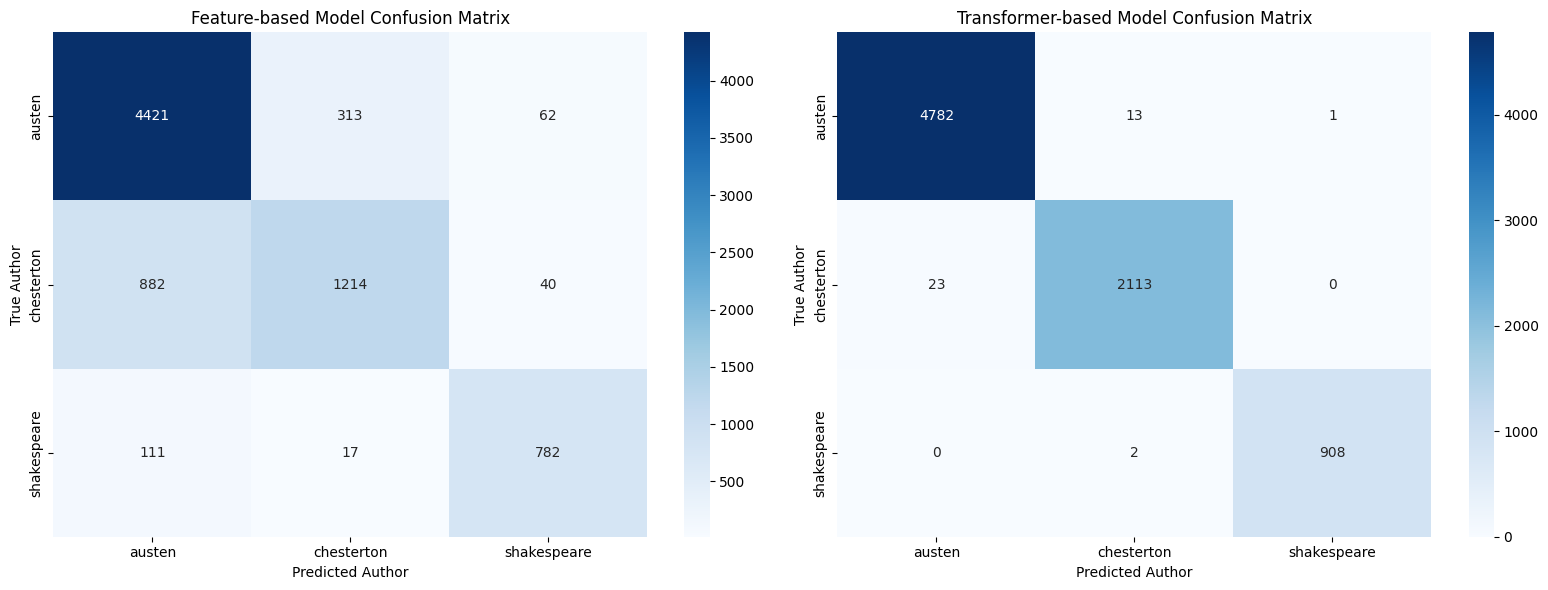


Found 1429 examples where models disagree.

Example disagreements:

Example 1:
Text snippet: [ Emma by Jane Austen 1816 ] VOLUME I CHAPTER I Emma Woodhouse , handsome , clever , and rich , with...
True author: austen
Feature-based prediction: chesterton
Transformer-based prediction: austen

Example 2:
Text snippet: and how nursed her through the various illnesses of childhood . A large debt of gratitude was owing ...
True author: austen
Feature-based prediction: chesterton
Transformer-based prediction: austen

Example 3:
Text snippet: and who had such an affection for her as could never find fault . How was she to bear the change ? -...
True author: austen
Feature-based prediction: chesterton
Transformer-based prediction: austen

Example 4:
Text snippet: was aware that great must be the difference between a Mrs. Weston , only half a mile from them , and...
True author: austen
Feature-based prediction: chesterton
Transformer-based prediction: austen

Example 5:
Text snippet: thought of

In [ ]:
compare1 = compare_predictions(
    feature_preds=predictions1,
    transformer_pred_tuple=t_predictions1,
    true_labels=labels1,
    author_to_idx=author_to_idx1,
    samples=samples1
)

##### Set 2
- bible-kjv.txt
- blake-poems.txt
- bryant-stories.txt


Model Comparison Results:
Feature-based model accuracy: 0.9933
Transformer-based model accuracy: 0.9997
Agreement between models: 0.9932


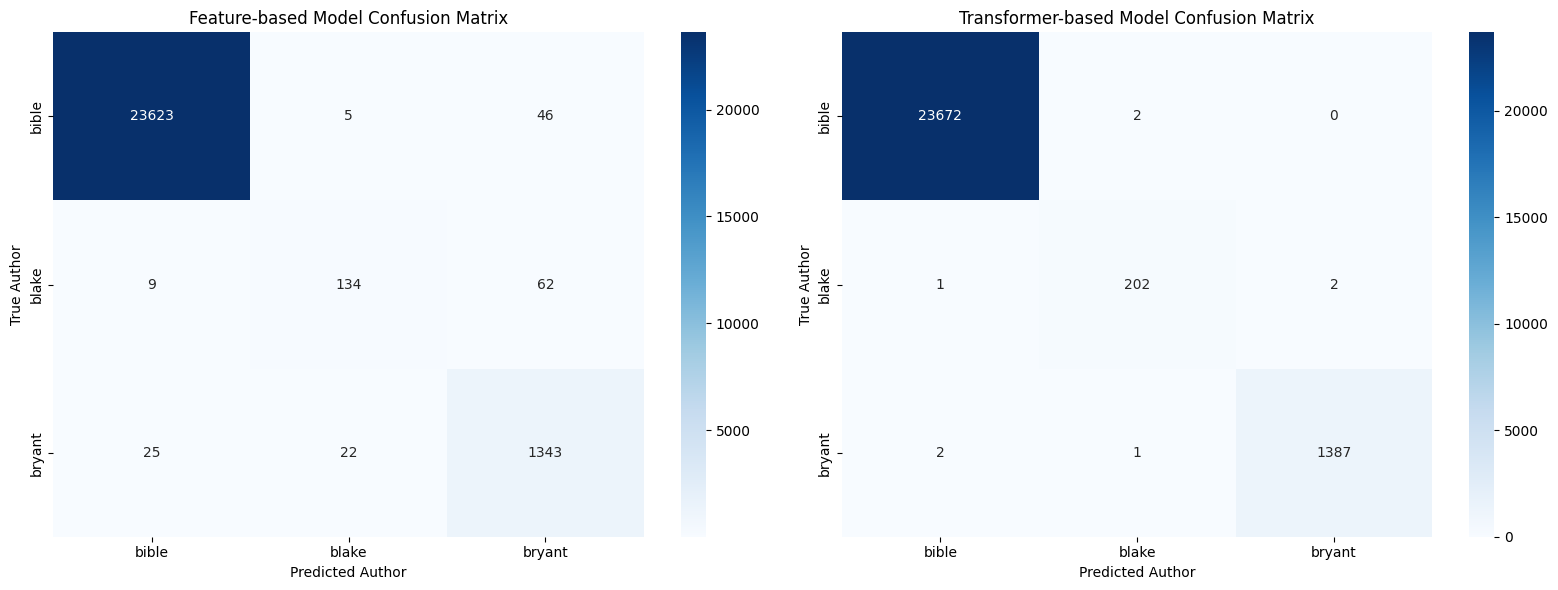


Found 173 examples where models disagree.

Example disagreements:

Example 1:
Text snippet: lords , turn in , I pray you , into your servant 's house , and tarry all night , and wash your feet...
True author: bible
Feature-based prediction: bryant
Transformer-based prediction: bible

Example 2:
Text snippet: he said , Is not he rightly named Jacob ? for he hath supplanted me these two times : he took away m...
True author: bible
Feature-based prediction: bryant
Transformer-based prediction: bible

Example 3:
Text snippet: And they said , The man asked us straitly of our state , and of our kindred , saying , Is your fathe...
True author: bible
Feature-based prediction: bryant
Transformer-based prediction: bible

Example 4:
Text snippet: Happy art thou , O Israel : who is like unto thee , O people saved by the LORD , the shield of thy h...
True author: bible
Feature-based prediction: blake
Transformer-based prediction: bible

Example 5:
Text snippet: Jael Heber 's wife took a nail of th

In [ ]:
compare2 = compare_predictions(
    feature_preds=predictions2,
    transformer_pred_tuple=t_predictions2,
    true_labels=labels2,
    author_to_idx=author_to_idx2,
    samples=samples2
)

##### Set 3
- burgess-busterbrown.txt
- carroll-alice.txt
- chesterton-ball.txt


Model Comparison Results:
Feature-based model accuracy: 0.8299
Transformer-based model accuracy: 0.9965
Agreement between models: 0.8277


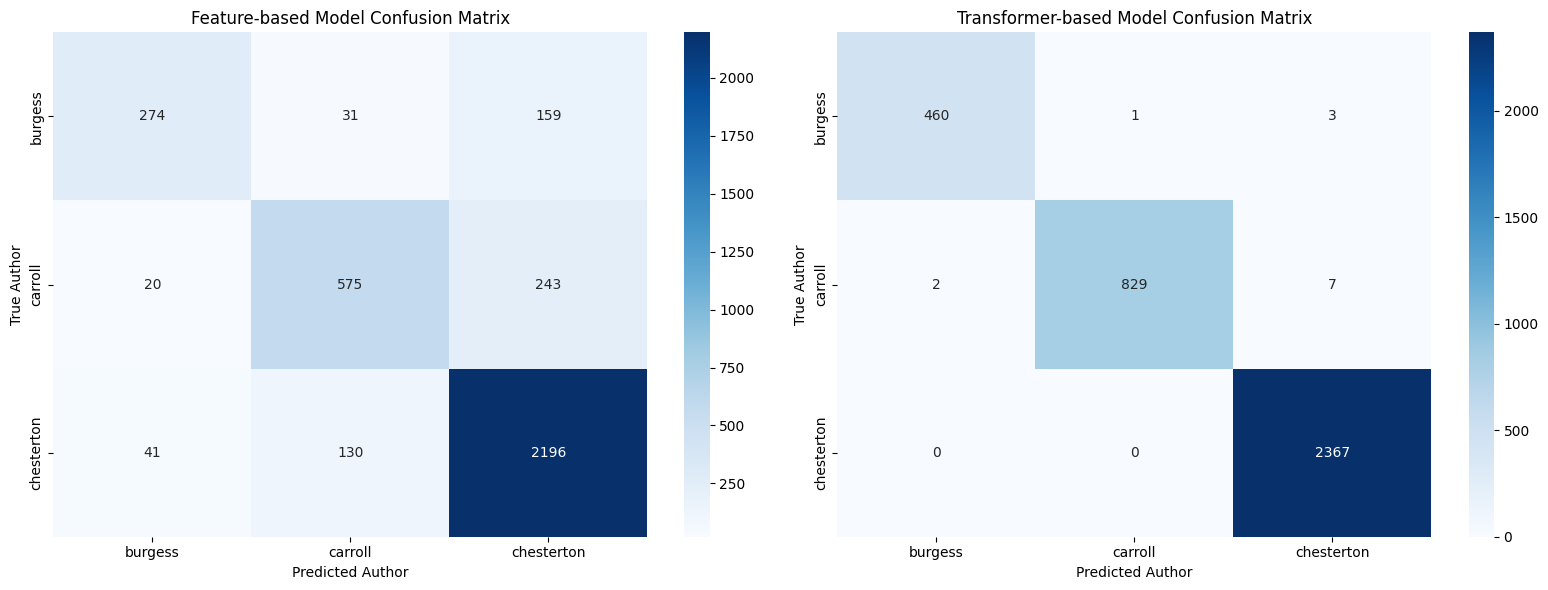


Found 632 examples where models disagree.

Example disagreements:

Example 1:
Text snippet: [ The Adventures of Buster Bear by Thornton W. Burgess 1920 ] I BUSTER BEAR GOES FISHING Buster Bear...
True author: burgess
Feature-based prediction: carroll
Transformer-based prediction: burgess

Example 2:
Text snippet: as high up on the trunk of the tree as he could , and scratched the bark with his great claws . Afte...
True author: burgess
Feature-based prediction: chesterton
Transformer-based prediction: burgess

Example 3:
Text snippet: to think what he wanted for breakfast . While he sat there , trying to make up his mind what would t...
True author: burgess
Feature-based prediction: chesterton
Transformer-based prediction: burgess

Example 4:
Text snippet: who live in the Green Forest . He heard Sammy Jay way off in the distance screaming , `` Thief ! Thi...
True author: burgess
Feature-based prediction: chesterton
Transformer-based prediction: burgess

Example 5:
Text snippet: stolen

In [ ]:
compare3 = compare_predictions(
    feature_preds=predictions3,
    transformer_pred_tuple=t_predictions3,
    true_labels=labels3,
    author_to_idx=author_to_idx3,
    samples=samples3
)

##### Set 4
- austen-persuasion.txt
- chesterton-thursday.txt
- shakespeare-macbeth.txt


Model Comparison Results:
Feature-based model accuracy: 0.8206
Transformer-based model accuracy: 0.9954
Agreement between models: 0.8208


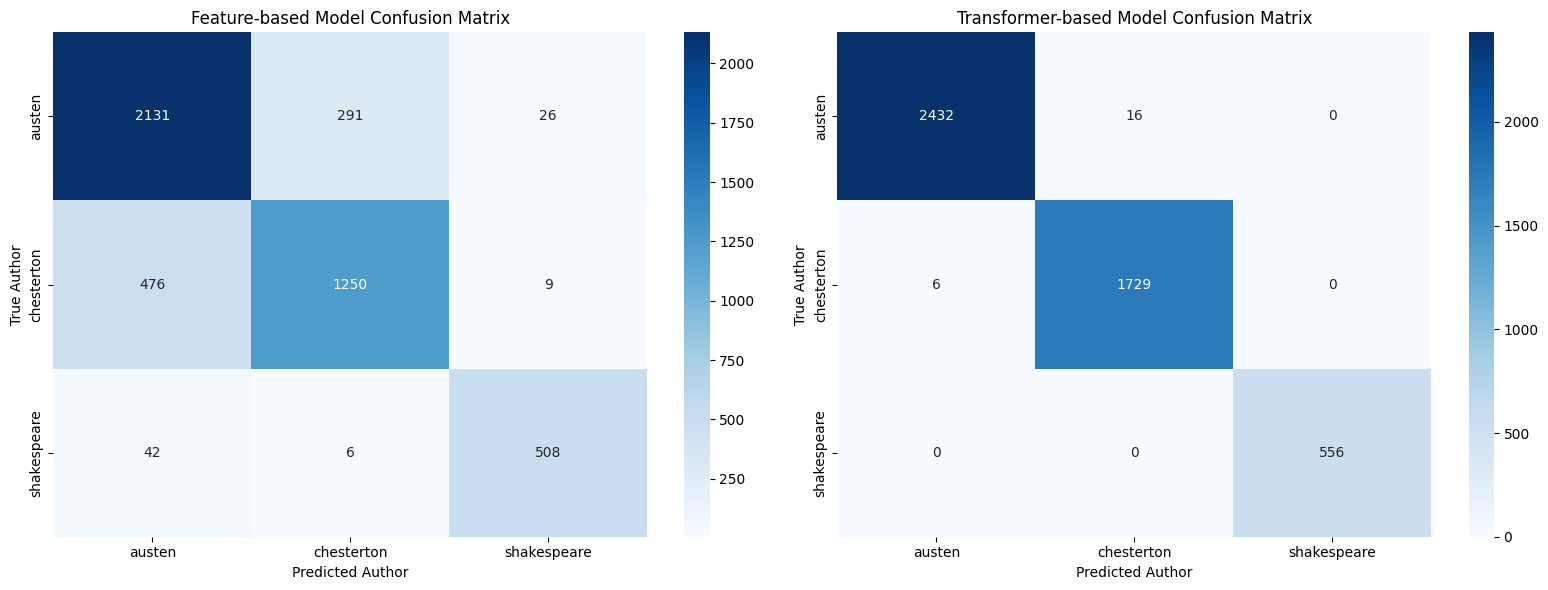


Found 849 examples where models disagree.

Example disagreements:

Example 1:
Text snippet: at fifty-four , was still a very fine man . Few women could think more of their personal appearance ...
True author: austen
Feature-based prediction: chesterton
Transformer-based prediction: austen

Example 2:
Text snippet: in society . He considered the blessing of beauty as inferior only to the blessing of a baronetcy ; ...
True author: austen
Feature-based prediction: chesterton
Transformer-based prediction: austen

Example 3:
Text snippet: the rest of his family and acquaintance were growing . Anne haggard , Mary coarse , every face in th...
True author: austen
Feature-based prediction: chesterton
Transformer-based prediction: austen

Example 4:
Text snippet: the table near her , had she closed it , with averted eyes , and pushed it away . She had had a disa...
True author: austen
Feature-based prediction: chesterton
Transformer-based prediction: austen

Example 5:
Text snippet: must ever p

In [ ]:
compare4 = compare_predictions(
    feature_preds=predictions4,
    transformer_pred_tuple=t_predictions4,
    true_labels=labels4,
    author_to_idx=author_to_idx4,
    samples=samples4
)

##### Set 5
- melville-moby_dick.txt
- milton-paradise.txt
- shakespeare-caesar.txt


Model Comparison Results:
Feature-based model accuracy: 0.9418
Transformer-based model accuracy: 0.9967
Agreement between models: 0.9394


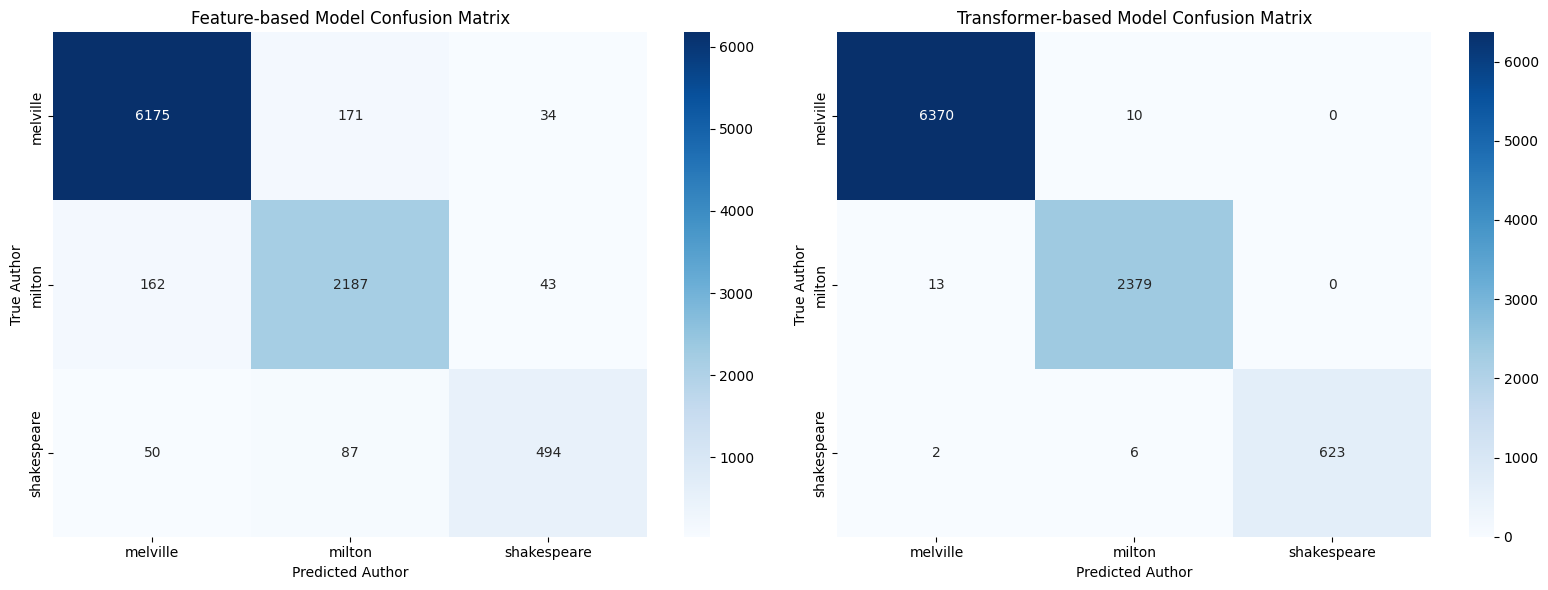


Found 570 examples where models disagree.

Example disagreements:

Example 1:
Text snippet: by many nations and generations , including our own . So fare thee well , poor devil of a Sub-Sub , ...
True author: melville
Feature-based prediction: milton
Transformer-based prediction: melville

Example 2:
Text snippet: who have gone before are clearing out the seven-storied heavens , and making refugees of long-pamper...
True author: melville
Feature-based prediction: milton
Transformer-based prediction: melville

Example 3:
Text snippet: In that day , the Lord with his sore , and great , and strong sword , shall punish Leviathan the pie...
True author: melville
Feature-based prediction: shakespeare
Transformer-based prediction: melville

Example 4:
Text snippet: sea . '' -- ISAIAH `` And what thing soever besides cometh within the chaos of this monster 's mouth...
True author: melville
Feature-based prediction: milton
Transformer-based prediction: melville

Example 5:
Text snippet: to sec

In [ ]:
compare5 = compare_predictions(
    feature_preds=predictions5,
    transformer_pred_tuple=t_predictions5,
    true_labels=labels5,
    author_to_idx=author_to_idx5,
    samples=samples5
)

##### Set 6
- austen-sense.txt
- edgeworth-parents.txt
- whitman-leaves.txt


Model Comparison Results:
Feature-based model accuracy: 0.7821
Transformer-based model accuracy: 0.9894
Agreement between models: 0.7809


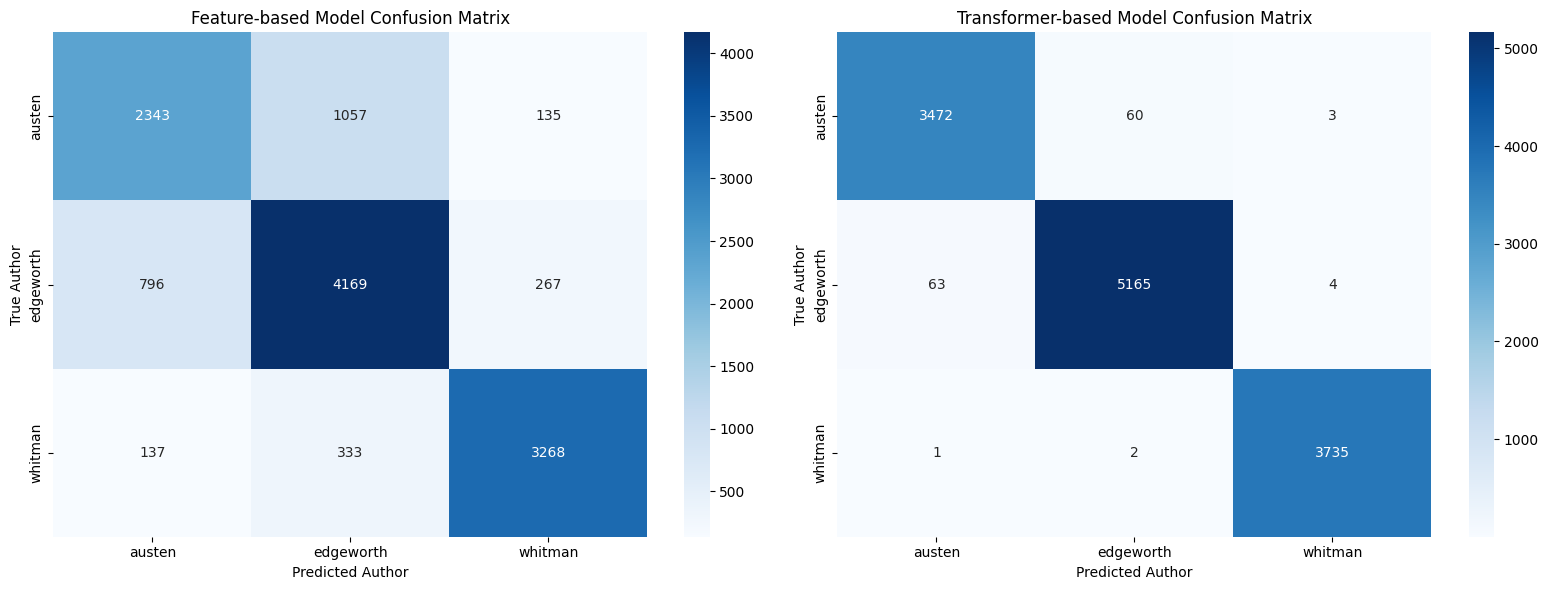


Found 2740 examples where models disagree.

Example disagreements:

Example 1:
Text snippet: [ Sense and Sensibility by Jane Austen 1811 ] CHAPTER 1 The family of Dashwood had long been settled...
True author: austen
Feature-based prediction: edgeworth
Transformer-based prediction: austen

Example 2:
Text snippet: great alteration in his home ; for to supply her loss , he invited and received into his house the f...
True author: austen
Feature-based prediction: whitman
Transformer-based prediction: austen

Example 3:
Text snippet: whom he intended to bequeath it . In the society of his nephew and niece , and their children , the ...
True author: austen
Feature-based prediction: edgeworth
Transformer-based prediction: austen

Example 4:
Text snippet: children added a relish to his existence . By a former marriage , Mr. Henry Dashwood had one son : b...
True author: austen
Feature-based prediction: edgeworth
Transformer-based prediction: austen

Example 5:
Text snippet: the sake of his 

In [ ]:
compare6 = compare_predictions(
    feature_preds=predictions6,
    transformer_pred_tuple=t_predictions6,
    true_labels=labels6,
    author_to_idx=author_to_idx6,
    samples=samples6
)

#### Comparing Metrics

A comprehensive evaluation of the two approaches is conducted by calculating and analyzing key performance metrics, including accuracy, precision, recall, F1-score, and confusion matrices. This comparison provides a detailed understanding of the strengths and limitations of each method in the context of author attribution.

##### Set 1
- austen-emma.txt = 0
- chesterton-brown.txt = 1
- shakespeare-hamlet.txt = 2

**Performance**

|                 | Precision (Feature)  | Precision (Transformer) | Recall (Feature)  | Recall (Transformer) | F1-Score (Feature) | F1-Score (Transformer) | Support (Feature) | Support (Transformer) |
|-----------------|----------------------|--------------------------|-------------------|-----------------------|--------------------|------------------------|-------------------|-----------------------|
| 0          | 0.79                 | 0.98                     | 0.90              | 0.99                  | 0.84               | 0.98                   | 946               | 960                   |
| 1      | 0.74                 | 0.96                     | 0.53              | 0.95                  | 0.62               | 0.96                   | 439               | 427                   |
| 2     | 0.84                 | 0.99                     | 0.81              | 0.99                  | 0.83               | 0.99                   | 184               | 182                   |
| **Accuracy**    |                      |                          |                   |                       | 0.78               | 0.98                   | 1569              | 1569                  |
| **Macro Avg**   | 0.79                 | 0.98                     | 0.75              | 0.97                  | 0.76               | 0.98                   | 1569              | 1569                  |
| **Weighted Avg**| 0.78                 | 0.98                     | 0.78              | 0.98                  | 0.78               | 0.98                   | 1569              | 1569                  |

**Combined Confusion Matrix**
|     | 0 (Feature) | 0 (Transformer) | 1 (Feature) | 1 (Transformer) | 2 (Feature) | 2 (Transformer) |
|-----|-------------|-----------------|-------------|-----------------|-------------|-----------------|
| 0   | 849         | 946             | 79          | 13              | 18          | 1               |
| 1   | 196         | 23              | 233         | 404             | 10          | 0               |
| 2   | 33          | 0               | 2           | 2               | 149         | 180             |

##### Set 2
- bible-kjv.txt = 0
- blake-poems.txt = 1
- bryant-stories.txt = 2

**Performance**

|                 | Precision (Feature)  | Precision (Transformer) | Recall (Feature)  | Recall (Transformer) | F1-Score (Feature) | F1-Score (Transformer) | Support (Feature) | Support (Transformer) |
|-----------------|----------------------|--------------------------|-------------------|-----------------------|--------------------|------------------------|-------------------|-----------------------|
| 0               | 1.00                 | 1.00                     | 1.00              | 1.00                  | 1.00               | 1.00                   | 4727              | 4735                  |
| 1               | 0.68                 | 0.93                     | 0.39              | 0.93                  | 0.49               | 0.93                   | 44                | 41                    |
| 2               | 0.91                 | 0.99                     | 0.95              | 0.99                  | 0.93               | 0.99                   | 283               | 278                   |
| **Accuracy**    |                      |                          |                   |                       | 0.99               | 1.00                   | 5054              | 5054                  |
| **Macro Avg**   | 0.86                 | 0.97                     | 0.78              | 0.97                  | 0.81               | 0.97                   | 5054              | 5054                  |
| **Weighted Avg**| 0.99                 | 1.00                     | 0.99              | 1.00                  | 0.99               | 1.00                   | 5054              | 5054                  |

**Confusion Matrix**
|     | 0 (Feature) | 0 (Transformer) | 1 (Feature) | 1 (Transformer) | 2 (Feature) | 2 (Transformer) |
|-----|-------------|-----------------|-------------|-----------------|-------------|-----------------|
| 0   | 4720        | 4733            | 1           | 2               | 6           | 0               |
| 1   | 5           | 1               | 17          | 38              | 22          | 2               |
| 2   | 7           | 2               | 7           | 1               | 269         | 275             |

##### Set 3
- burgess-busterbrown.txt = 0
- carroll-alice.txt = 1
- chesterton-ball.txt = 2

**Performance**

|                 | Precision (Feature)  | Precision (Transformer) | Recall (Feature)  | Recall (Transformer) | F1-Score (Feature) | F1-Score (Transformer) | Support (Feature) | Support (Transformer) |
|-----------------|----------------------|--------------------------|-------------------|-----------------------|--------------------|------------------------|-------------------|-----------------------|
| 0               | 0.79                 | 0.98                     | 0.47              | 0.96                  | 0.59               | 0.97                   | 117               | 93                    |
| 1               | 0.72                 | 0.99                     | 0.63              | 0.95                  | 0.67               | 0.97                   | 163               | 168                   |
| 2               | 0.79                 | 0.98                     | 0.91              | 1.00                  | 0.84               | 0.99                   | 454               | 473                   |
| **Accuracy**    |                      |                          |                   |                       | 0.78               | 0.98                   | 734               | 734                   |
| **Macro Avg**   | 0.76                 | 0.98                     | 0.67              | 0.97                  | 0.70               | 0.98                   | 734               | 734                   |
| **Weighted Avg**| 0.77                 | 0.98                     | 0.78              | 0.98                  | 0.76               | 0.98                   | 734               | 734                   |

**Confusion Matrix**

|     | 0 (Feature) | 0 (Transformer) | 1 (Feature) | 1 (Transformer) | 2 (Feature) | 2 (Transformer) |
|-----|-------------|-----------------|-------------|-----------------|-------------|-----------------|
| 0   | 55          | 89              | 10          | 1               | 52          | 3               |
| 1   | 3           | 2               | 103         | 159             | 57          | 7               |
| 2   | 12          | 0               | 31          | 0               | 411         | 473             |


##### Set 4
- austen-persuasion.txt = 0
- chesterton-thursday.txt = 1
- shakespeare-macbeth.txt = 2

**Performance**

|                 | Precision (Feature)  | Precision (Transformer) | Recall (Feature)  | Recall (Transformer) | F1-Score (Feature) | F1-Score (Transformer) | Support (Feature) | Support (Transformer) |
|-----------------|----------------------|--------------------------|-------------------|-----------------------|--------------------|------------------------|-------------------|-----------------------|
| 0               | 0.77                 | 0.99                     | 0.87              | 0.97                  | 0.81               | 0.98                   | 494               | 490                   |
| 1               | 0.78                 | 0.96                     | 0.65              | 0.98                  | 0.71               | 0.97                   | 349               | 347                   |
| 2               | 0.94                 | 1.00                     | 0.89              | 1.00                  | 0.91               | 1.00                   | 105               | 111                   |
| **Accuracy**    |                      |                          |                   |                       | 0.79               | 0.98                   | 948               | 948                   |
| **Macro Avg**   | 0.83                 | 0.98                     | 0.80              | 0.98                  | 0.81               | 0.98                   | 948               | 948                   |
| **Weighted Avg**| 0.79                 | 0.98                     | 0.79              | 0.98                  | 0.79               | 0.98                   | 948               | 948                   |

**Confusion Matrix**

|     | 0 (Feature) | 0 (Transformer) | 1 (Feature) | 1 (Transformer) | 2 (Feature) | 2 (Transformer) |
|-----|-------------|-----------------|-------------|-----------------|-------------|-----------------|
| 0   | 428         | 474             | 62          | 16              | 4           | 0               |
| 1   | 121         | 6               | 226         | 341             | 2           | 0               |
| 2   | 10          | 0               | 2           | 0               | 93          | 111             |


##### Set 5
- melville-moby_dick.txt = 0  
- milton-paradise.txt = 1  
- shakespeare-caesar.txt = 2  

**Performance**

|                 | Precision (Feature)  | Precision (Transformer) | Recall (Feature)  | Recall (Transformer) | F1-Score (Feature) | F1-Score (Transformer) | Support (Feature) | Support (Transformer) |
|-----------------|----------------------|--------------------------|-------------------|-----------------------|--------------------|------------------------|-------------------|-----------------------|
| 0               | 0.96                 | 0.99                     | 0.96              | 0.99                  | 0.96               | 0.99                   | 1284              | 1276                  |
| 1               | 0.87                 | 0.97                     | 0.90              | 0.97                  | 0.89               | 0.97                   | 477               | 479                   |
| 2               | 0.83                 | 1.00                     | 0.71              | 0.94                  | 0.76               | 0.97                   | 120               | 126                   |
| **Accuracy**    |                      |                          |                   |                       | 0.93               | 0.98                   | 1881              | 1881                  |
| **Macro Avg**   | 0.89                 | 0.99                     | 0.86              | 0.97                  | 0.87               | 0.98                   | 1881              | 1881                  |
| **Weighted Avg**| 0.93                 | 0.98                     | 0.93              | 0.98                  | 0.93               | 0.98                   | 1881              | 1881                  |

**Confusion Matrix**

|     | 0 (Feature) | 0 (Transformer) | 1 (Feature) | 1 (Transformer) | 2 (Feature) | 2 (Transformer) |
|-----|-------------|-----------------|-------------|-----------------|-------------|-----------------|
| 0   | 1238        | 1266            | 38          | 10              | 8           | 0               |
| 1   | 37          | 13              | 430         | 466             | 10          | 0               |
| 2   | 11          | 2               | 24          | 6               | 85          | 118             |


##### Set 6
- austen-sense.txt = 0  
- edgeworth-parents.txt = 1  
- whitman-leaves.txt = 2  

**Performance**

|                 | Precision (Feature)  | Precision (Transformer) | Recall (Feature)  | Recall (Transformer) | F1-Score (Feature) | F1-Score (Transformer) | Support (Feature) | Support (Transformer) |
|-----------------|----------------------|--------------------------|-------------------|-----------------------|--------------------|------------------------|-------------------|-----------------------|
| 0               | 0.69                 | 0.91                     | 0.64              | 0.91                  | 0.66               | 0.91                   | 725               | 707                   |
| 1               | 0.73                 | 0.94                     | 0.77              | 0.94                  | 0.75               | 0.94                   | 1042              | 1046                  |
| 2               | 0.87                 | 0.99                     | 0.86              | 1.00                  | 0.86               | 0.99                   | 734               | 748                   |
| **Accuracy**    |                      |                          |                   |                       | 0.76               | 0.95                   | 2501              | 2501                  |
| **Macro Avg**   | 0.76                 | 0.95                     | 0.76              | 0.95                  | 0.76               | 0.95                   | 2501              | 2501                  |
| **Weighted Avg**| 0.76                 | 0.95                     | 0.76              | 0.95                  | 0.76               | 0.95                   | 2501              | 2501                  |

**Confusion Matrix**

|     | 0 (Feature) | 0 (Transformer) | 1 (Feature) | 1 (Transformer) | 2 (Feature) | 2 (Transformer) |
|-----|-------------|-----------------|-------------|-----------------|-------------|-----------------|
| 0   | 462         | 644             | 230         | 60              | 33          | 3               |
| 1   | 172         | 63              | 805         | 979             | 65          | 4               |
| 2   | 35          | 1               | 66          | 2               | 633         | 745             |
